In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.datasets import make_classification
from sklearn import model_selection
import sklearn.base as skbase
from sklearn import metrics
from scipy import optimize

# Данные

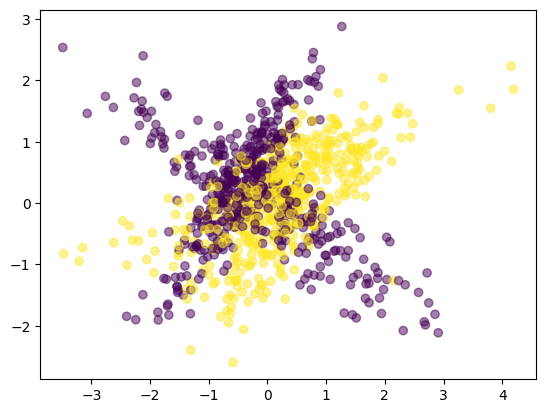

In [2]:
X, y = make_classification(
    n_samples=1000, n_features=2,  n_redundant=0, n_informative=2,
    hypercube=False
)
X = pd.DataFrame(data=X, columns=['f1', 'f2'])
y = pd.Series(data=y, name='target_class')
plt.scatter(X.iloc[:, 0], X.iloc[:,1], c=y.values, alpha=0.5)

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3)

# Algorighm

## utility functions

In [4]:
EPS = 1e-10

In [5]:
def x_logx(val):
    return val * np.log2(val + EPS)

x_logx(0.5)

-0.49999999985573046

In [6]:
def entropy(y):
    vc = y.value_counts() / len(y)
    return -x_logx(vc.values).sum()
entropy(y)

0.9999740310449117

# Tree

In [7]:
class Node():
    def predict(self, dct):
        raise NotADirectoryError()

class FeatureSplit(Node):
    
    def __init__(self, fname, thres, left, right):
        self.fname, self.thres = fname, thres
        self.left, self.right = left, right
        
    def predict(self, dct):
        if dct[self.fname] < self.thres:
            return self.left.predict(dct)
        else:
            return self.right.predict(dct)

class Leaf(Node):
    def __init__(self, value):
        self.value = value

    def predict(self, dct):
        return self.value

##  information gane

In [8]:
def split_entropy(X, y, fname, thres):
    y1 = y[X[fname] <= thres]
    y2 = y[X[fname] > thres]
    return len(y1)/len(y) * entropy(y1) + len(y2)/len(y) * entropy(y2)

def split_igane(X, y, fname, thres):
    return entropy(y) - split_entropy(X, y, fname, thres)

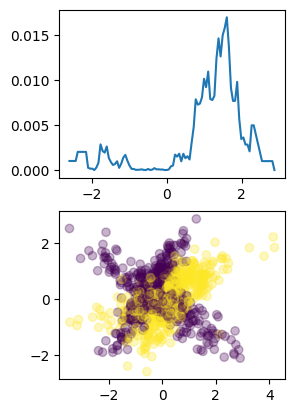

In [9]:
fname = 'f2'
thres_space = np.linspace(X[fname].min(), X[fname].max(), 100)
thres_igane = [
    split_igane(X, y, fname, thres)
    for thres in thres_space
]
plt.subplot(2, 2, 1)
plt.plot(thres_space, thres_igane)
plt.subplot(2, 2, 3)
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, alpha=0.3)

In [10]:
class GreadyTree(skbase.BaseEstimator):
    def __init__(self, max_depth=3, n_splits=100):
        self.tree = Node()
        self.max_depth = max_depth
        self.n_splits = n_splits

    def _make_tree(self, max_depth, X, y):
        if max_depth == 0 or y.sum() == 0 or y.sum() == len(y):
            return Leaf(y.mean())
        space = []
        igane = []
        for fname in X.columns:
            for thres in np.linspace(X[fname].min(), X[fname].max(), self.n_splits):
                space.append((fname, thres))
                igane.append(split_igane(X, y, fname, thres))
        fname, thres = space[np.argmax(igane)]
        left = X[fname] <= thres
        right = X[fname] > thres
        if len(left) == 0 or len(right) == 0:
            return Leaf(y.mean())
        return FeatureSplit(
            fname, thres,
            self._make_tree(max_depth-1, X[left], y[left]),
            self._make_tree(max_depth-1, X[right], y[right])
        )

    def fit(self, X, y):
        self.tree = self._make_tree(self.max_depth, X, y) 
        return self 
        
    def predict(self, X):
        return pd.Series(
            data=[
                self.tree.predict(row)
                for _, row in X.iterrows()
            ],
            index=X.index
        )

In [11]:
pspace = np.arange(1, 15)
train_roc_auc = []
test_roc_auc = []
for pval in tqdm(pspace):
    model = GreadyTree(max_depth=pval).fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    train_roc_auc.append(metrics.roc_auc_score(y_train, y_pred_train))
    test_roc_auc.append(metrics.roc_auc_score(y_test, y_pred_test))

  0%|          | 0/14 [00:00<?, ?it/s]

Text(0, 0.5, 'roc auc')

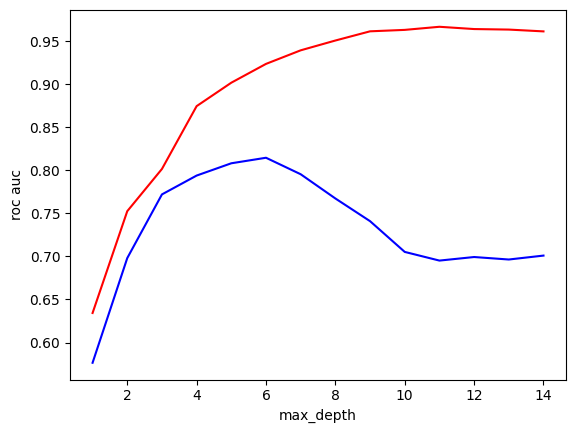

In [12]:
plt.plot(pspace, train_roc_auc, c='r', label='train')
plt.plot(pspace, test_roc_auc, c='b', label='test')
plt.xlabel('max_depth')
plt.ylabel('roc auc')

# Visualize

In [13]:
model = GreadyTree(max_depth=4).fit(X, y)

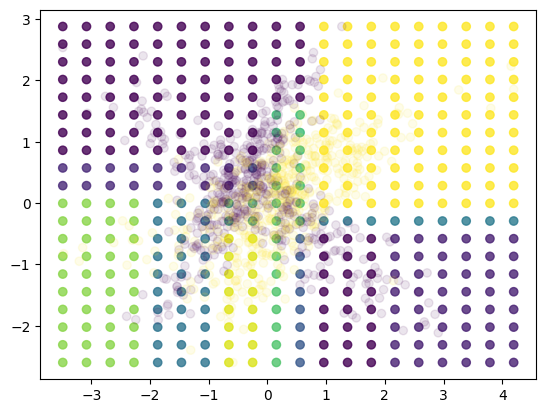

In [14]:
xs = pd.DataFrame(
    data=np.array([
        [f1, f2]
        for f1 in np.linspace(X['f1'].min(), X['f1'].max(), 20)
        for f2 in np.linspace(X['f2'].min(), X['f2'].max(), 20)
    ]),
    columns=['f1', 'f2']
)
ys = model.predict(xs)
plt.scatter(xs['f1'], xs['f2'], c=ys, alpha=0.8)
plt.scatter(X.loc[:, 'f1'], X.loc[:, 'f2'], c=y, alpha=0.1)